# Audio Emotion Classification

This notebook performs audio classification on both the raw audio and the features extracted from the audio. It is also capable of augmenting the pitch and length of the audio file. 

In [1]:
# Loading Packages
import librosa
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import os
from glob import glob
import math
import seaborn as sns
import scipy.signal as signal
from IPython.display import Audio
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Custom Functions
from john_romero_audio_functions import *
from john_romero_video_functions import *

In [2]:
# Getting Directories with Custom Function
cwd, data_dir, raw_dir, features_dir, metadata_dir, eda_dir, fig_dir, models_dir = get_aud_dirs()

In [3]:
# Mode = 'r': reading data from files
# Mode = 'w': writing data to files (feats only)
mode = 'r'
# augment_data: whether or not to augment the data
augment_data = False
# data_type = 'feats': using features
# data_type = 'raw' using raw data
data_type = 'feats'

In [4]:
# Loading/Writing the metadata file
metadata = get_metadata(mode='r', type='Audio')
# Splitting the metadata df into partitions
train, val, test = [metadata[metadata['partition'] == part] for part in ['train', 'val', 'test']]

In [5]:
# Get the data associated with each dataframe above
# note the mode/data/augment options
train_tar, train_feats = get_aud_data(train, mode=mode, data=data_type, metadata=metadata, augment=augment_data) 
val_tar, val_feats = get_aud_data(val, mode=mode, data=data_type, metadata=metadata, augment=augment_data)
test_tar, test_feats = get_aud_data(test, mode=mode, data=data_type, metadata=metadata, augment=augment_data)

In [6]:
# Using TF String Lookup to One-Hot Encode the categories
cat_lookup = tf.keras.layers.StringLookup(num_oov_indices=0, 
                                          vocabulary = np.unique(metadata.category).tolist(), 
                                          output_mode='one_hot')
# One-hot encoding each observation in each partition
train_tar_oh, val_tar_oh, test_tar_oh = [np.stack([cat_lookup(tar) for tar in part]) for part in [train_tar, val_tar, test_tar]]

In [7]:
# Padding data to equal length
# Imperative since CNN layers need input data with equal length
# 1D padding for the raw data with numpy 
if data_type == 'raw':
    # Maximum Length of Audio Files
    maxlen = np.max([f.shape[0] for f in train_feats])
    # Padding the time series to have length equal to the maximum
    train_feats = np.expand_dims(np.stack([np.pad(f, pad_width = (maxlen-f.shape[0], 0)) for f in train_feats]), axis=2)
    val_feats = np.expand_dims(np.stack([np.pad(f, pad_width = (maxlen-f.shape[0], 0)) for f in val_feats]), axis=2)
    test_feats = np.expand_dims(np.stack([np.pad(f, pad_width = (maxlen-f.shape[0], 0)) for f in test_feats]), axis=2)
# 2D Padding the features data in the time dimension, similar to above
elif data_type == 'feats': 
    maxlen = np.max([f.shape[0] for f in train_feats])
    train_feats = np.stack([np.pad(f, pad_width = ((maxlen-f.shape[0], 0), (0, 0))) for f in train_feats])
    val_feats = np.stack([np.pad(f, pad_width = ((maxlen-f.shape[0], 0), (0, 0))) for f in val_feats])
    test_feats = np.stack([np.pad(f, pad_width = ((maxlen-f.shape[0], 0),(0, 0))) for f in test_feats])

In [8]:
# Extract the input shape for the first layer
shape = [train_feats.shape[-2], train_feats.shape[-1]]

In [9]:
# Fit Normalization Layer using the training data
norm_layer = tf.keras.layers.Normalization(axis=-1, name='FeatNorm')
norm_layer.adapt(train_feats)

# Define Feats Model Architecture 
if data_type == 'feats': 
    model = tf.keras.models.Sequential(name='AudioFeatModel', layers=[  

        # Input Layer
        tf.keras.layers.Input(shape = shape), 
        # Normalization Layer (adapted above) 
        norm_layer,

        # Convolution Layer 
        tf.keras.layers.Conv1D(64, kernel_size=7, strides=2, padding='same', 
                               activation=None, kernel_initializer='he_normal', name='1DConv'),
        tf.keras.layers.BatchNormalization(name='BatchNorm'), 
        tf.keras.layers.Activation('relu', name='ReLU'),

        # BI-LSTM Layer 
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(128, return_sequences=True, return_state=False, 
                                 dropout=0.2, recurrent_dropout=0.1), name='BiLSTM1'
        ),
        
        # BI-LSTM Layer 
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(64, return_sequences=True, return_state=False, 
                                 dropout=0.2, recurrent_dropout=0.1), name='BiLSTM2'
        ),

        # BI-LSTM Layer 
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(64, return_sequences=False, return_state=False,
                                 dropout=0.2, recurrent_dropout=0.1), name='BiLSTM3'
        ),

        # Output Layer
        tf.keras.layers.Dense(7, activation='softmax', name='Softmax')
    ])
    
# Define Raw Model Architecture 
elif data_type == 'raw':

    # Setting Filter Size and Stride to result in the same number of samples as the audio features
    filter_size = int(16000 / 1000 * 25)
    strides = int(16000 / 1000 * 10)
    
    model = tf.keras.models.Sequential(name='RawModel', layers=[  

        # Input Layer
        tf.keras.layers.Input(shape = shape),

        # Normalization Layer
        norm_layer,

        # Convolution Layer
        tf.keras.layers.Conv1D(64, kernel_size=filter_size, strides=strides, name = 'Conv1',
                               kernel_initializer='he_normal', padding='same'),
        tf.keras.layers.BatchNormalization(name='BatchNorm1'), 
        tf.keras.layers.Activation('relu', name='ReLU1'),

        # Convolution Layer
        tf.keras.layers.Conv1D(128, kernel_size=7, strides=2, padding='same',  
                               activation=None, kernel_initializer='he_normal', name='Conv2'),
        tf.keras.layers.BatchNormalization(name='BatchNorm2'), 
        tf.keras.layers.Activation('relu', name='ReLU'),

        # Bi-LSTM Layer 
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(128, return_sequences=True, return_state=False, 
                                 dropout=0.2, recurrent_dropout=0.1), name='BiLSTM1'
        ),

        # Bi-LSTM Layer
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(64, return_sequences=True, return_state=False, 
                                 dropout=0.2, recurrent_dropout=0.1), name='BiLSTM2'
        ),
        
        # Bi-LSTM Layer
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(64, return_sequences=False, return_state=False,
                                 dropout=0.2, recurrent_dropout=0.1), name='BiLSTM3'
        ),

        # Output Layer 
        tf.keras.layers.Dense(7, activation='softmax', name='Softmax')
    ])  

In [10]:
# Batch Size
batch_size = 56

# Epochs
n_epochs = 50

# Exponential Decay Learning Schedule 
steps = n_epochs * math.ceil(len(train_feats) / batch_size)
schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0005, 
                                                          decay_steps = steps, decay_rate=0.1) 
# Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=schedule)

# Compile Model
model.compile(optimizer = opt, 
              loss = 'categorical_crossentropy',
              metrics=['accuracy']
             )

In [11]:
# Display Model
model.summary()

Model: "AudioFeatModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FeatNorm (Normalization)    (None, 528, 32)           65        
                                                                 
 1DConv (Conv1D)             (None, 264, 64)           14400     
                                                                 
 BatchNorm (BatchNormalizati  (None, 264, 64)          256       
 on)                                                             
                                                                 
 ReLU (Activation)           (None, 264, 64)           0         
                                                                 
 BiLSTM1 (Bidirectional)     (None, 264, 256)          197632    
                                                                 
 BiLSTM2 (Bidirectional)     (None, 264, 128)          164352    
                                                    

In [12]:
# Model Name
if augment_data:
    model_fname = os.path.join(models_dir, f'cnn_bilstm_{data_type}_model_augmented.h5')
else:
    model_fname = os.path.join(models_dir, f'cnn_bilstm_{data_type}_model.h5')

# Callback to Save Model with Minimum Val Loss
callback_list = [
       tf.keras.callbacks.ModelCheckpoint(
           filepath= model_fname, 
           verbose=1, save_freq='epoch', 
           monitor='val_loss', save_best_only=True, mode='min'
       )         
]

In [13]:
# Training the model
history = model.fit(train_feats, train_tar_oh,
                    epochs=n_epochs, batch_size=batch_size,
                    validation_data=(val_feats, val_tar_oh),
                    callbacks=callback_list, 
                    verbose=1
                   )

Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 1.9314 - accuracy: 0.2153
Epoch 1: val_loss improved from inf to 1.87371, saving model to C:\Users\johnd\Documents\MSDS\Capstone\Final\Models\cnn_bilstm_feats_model.h5
18/18 [==============================] - 56s 3s/step - loss: 1.9314 - accuracy: 0.2153 - val_loss: 1.8737 - val_accuracy: 0.2731
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 1.8286 - accuracy: 0.2808
Epoch 2: val_loss improved from 1.87371 to 1.78706, saving model to C:\Users\johnd\Documents\MSDS\Capstone\Final\Models\cnn_bilstm_feats_model.h5
18/18 [==============================] - 45s 3s/step - loss: 1.8286 - accuracy: 0.2808 - val_loss: 1.7871 - val_accuracy: 0.2963
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 1.7324 - accuracy: 0.3323
Epoch 3: val_loss improved from 1.78706 to 1.74560, saving model to C:\Users\johnd\Documents\MSDS\Capstone\Final\Models\cnn_bilstm_feats_model.h5
18/18 [===================

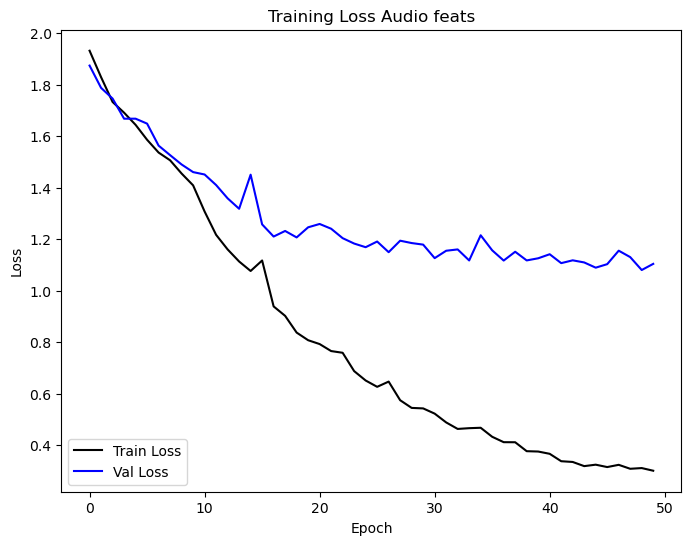

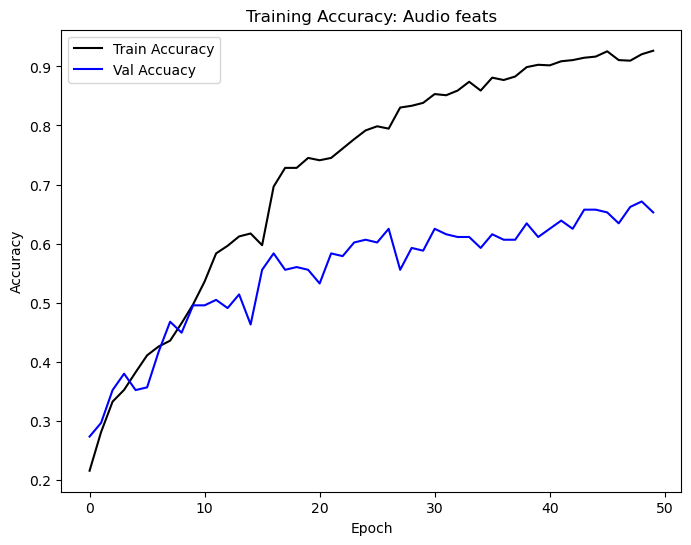

In [14]:
# Training Loss Plot File Name 
if augment_data: os.path.join(fig_dir, f'training_loss_{data_type}_augmented.png')
else: train_loss_fn = os.path.join(fig_dir, f'training_loss_{data_type}.png')

# Training Accuracy Plot File Name
if augment_data: train_acc_fn = os.path.join(fig_dir, f'training_acc_{data_type}_augmented.png') 
else: train_acc_fn = os.path.join(fig_dir, f'training_acc_{data_type}.png')

# Plot the model training
plot_history(history, 
             loss_fn = train_loss_fn, 
             acc_fn = train_acc_fn, 
             loss_title = f'Training Loss Audio {data_type}', 
             acc_title = f'Training Accuracy: Audio {data_type}')

In [15]:
# Reloading the best model 
best_model = tf.keras.models.load_model(filepath = model_fname)

# Gathering Test Set Predictions
test_preds = best_model.predict(test_feats)

7/7 [==============================] - 2s 232ms/step


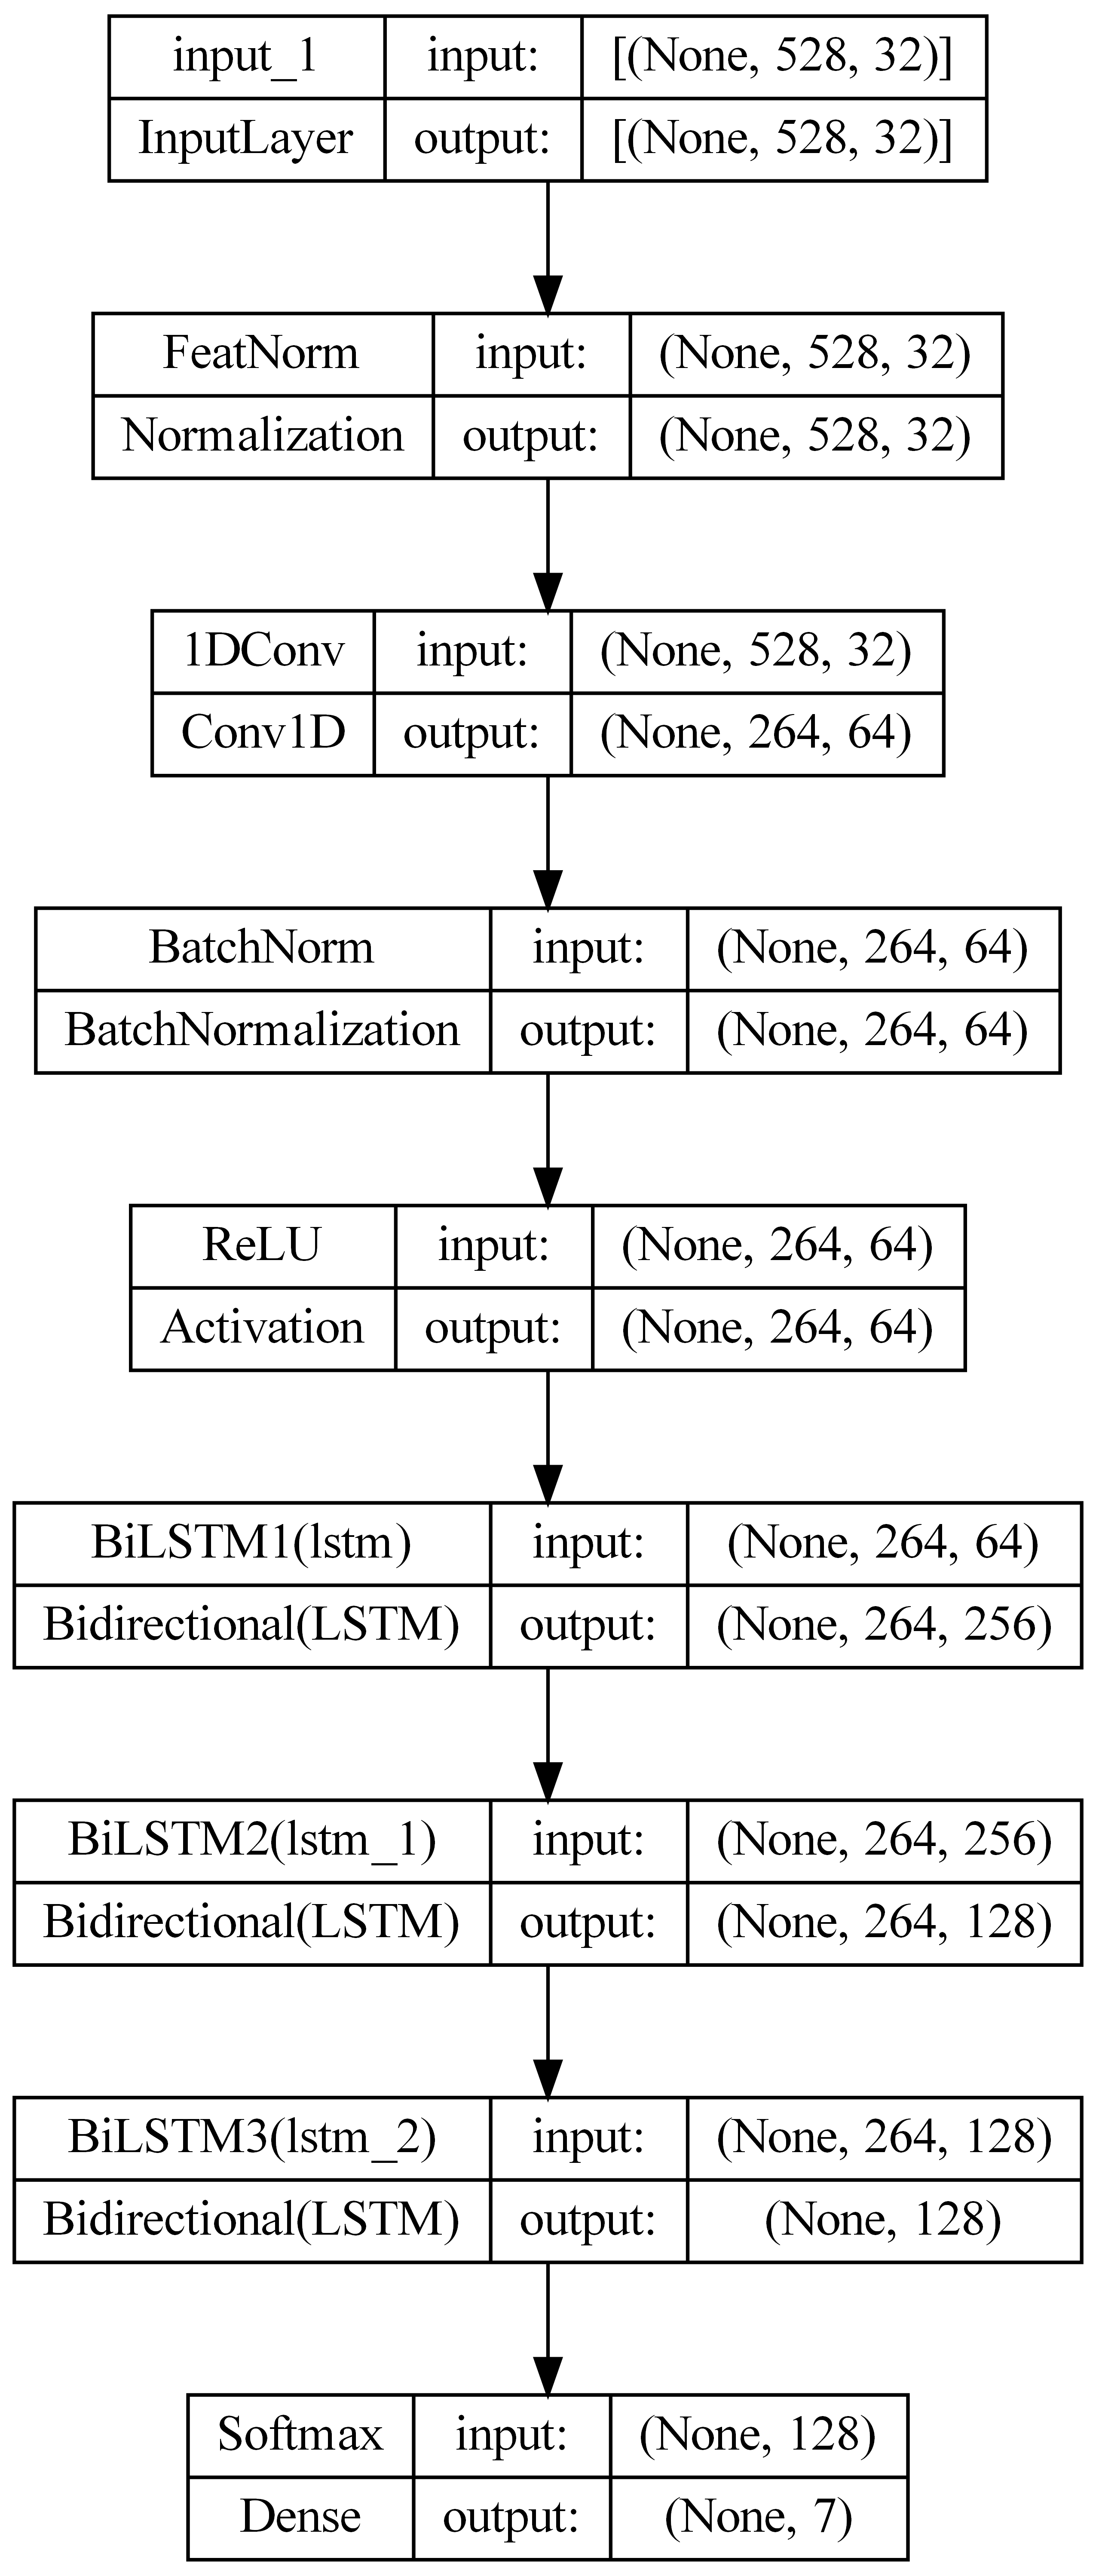

In [16]:
# Plotting the saved model
tf.keras.utils.plot_model(best_model, 
                          to_file = os.path.join(fig_dir, 'audio_model_plot.png'),
                          show_layer_names=True,
                          dpi = 600,
                          show_shapes = True)

In [17]:
# Getting the Predictions from the Model
test_preds = np.argmax(test_preds, axis=1, keepdims = True)
# One-Hot Encoding the predictions
test_preds = tf.keras.utils.to_categorical(test_preds).astype(np.int64).tolist()
# Getting the predicted category 
pred = [inv_label(pred) for pred in test_preds]

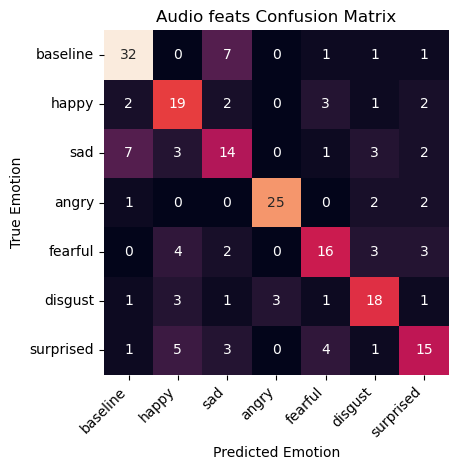

In [18]:
# Test Confusion Matrix File Name
if augment_data: cm_fname = os.path.join(fig_dir, f'test_cm_{data_type}.png')
else: cm_fname = os.path.join(fig_dir, f'test_cm_{data_type}.png')


categories = ['baseline', 'happy', 'sad', 'angry',
             'fearful', 'disgust','surprised']

cm = confusion_matrix(y_true = test_tar, y_pred = pred, labels=categories)
fig, ax = plt.subplots()

plt.title(f'Audio {data_type} Confusion Matrix')
sns.heatmap(cm, ax=ax, annot=True, cbar=False, square=True)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.set_yticklabels(categories, rotation=0, ha='right')
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.tight_layout()
plt.savefig(cm_fname)
plt.show()

In [19]:
# Showing Classification Report for Test Set
print(f'Testing Set Accuracy: {accuracy_score(test_tar, pred)}')
print(classification_report(y_true=test_tar, y_pred=pred))

Testing Set Accuracy: 0.6435185185185185
              precision    recall  f1-score   support

       angry       0.89      0.83      0.86        30
    baseline       0.73      0.76      0.74        42
     disgust       0.62      0.64      0.63        28
     fearful       0.62      0.57      0.59        28
       happy       0.56      0.66      0.60        29
         sad       0.48      0.47      0.47        30
   surprised       0.58      0.52      0.55        29

    accuracy                           0.64       216
   macro avg       0.64      0.64      0.64       216
weighted avg       0.65      0.64      0.64       216

